In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time, sys
from IPython.display import clear_output, display
from time import sleep
import random
from tabulate import tabulate

In [3]:
%run -i ./Classes.ipynb

# Embed, Attack, Extract

In [4]:
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

image_size = 160
logo_size = 20
tf_step = 2

my_image = Image(ori_img, image_size)
my_logo = Logo(ori_logo, logo_size)

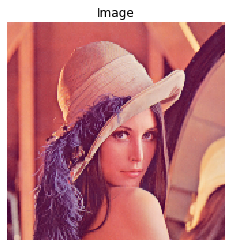

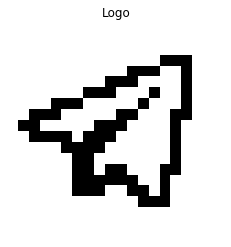

In [5]:
ImageUtil.show1(my_image.image, 'Image', 4)
ImageUtil.show1(my_logo.logo, 'Logo', 4)

# Method 1

'Transform PCET: [####################] 100.0%'

'Inverse PCET: [####################] 100.0%'

PSNR = 31.934682827043638


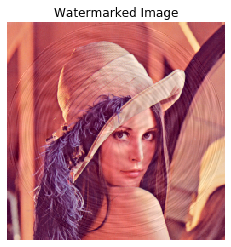

In [36]:
riw = RIW(image_size, logo_size, logo_size * 2, 0.5, tf_step)
img_y_watermarked = riw.embed(my_image.get_y(), my_logo.logo)
w_image = Image.copy(my_image)
w_image.set_y(img_y_watermarked)

print('PSNR = {}'.format(ImageUtil.psnr(my_image.image, w_image.image)))

ImageUtil.show1(w_image.image, 'Watermarked Image')

'Transform PCET: [####################] 100.0%'

BER = 0.00%


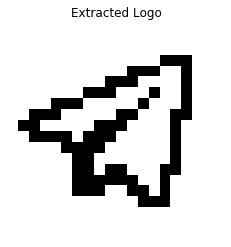

In [37]:
logo_extracted = riw.extract(w_image.get_y())

print('BER = {:.2%}'.format(ImageUtil.ber(my_logo.logo, logo_extracted)))

ImageUtil.show1(logo_extracted, 'Extracted Logo')

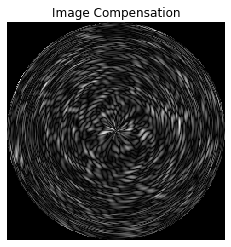

In [17]:
ImageUtil.show1(riw.img_compensation, 'Image Compensation')

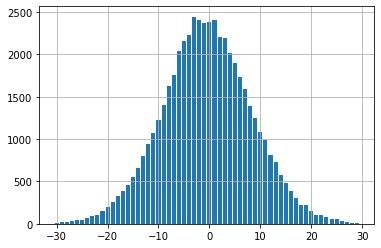

In [38]:
# Histogram of Compensation Image

fig_histogram = plt.figure()
histogram_data = riw.img_compensation.flatten()
histogram_data = histogram_data[histogram_data != 0]
(yaxis, xaxis) = np.histogram(histogram_data, bins=np.linspace(-30, 30, 61))
xaxis = xaxis[0:len(yaxis)]
plt.bar(xaxis, yaxis)
plt.grid()
plt.show()

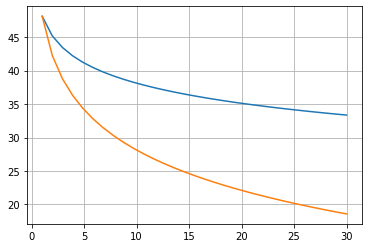

In [26]:
# Graph of PSNR

fig_psnr = plt.figure()
xaxis_psnr = np.linspace(1, 30, 31)
plt.plot(xaxis_psnr, 10 * np.log10(255 ** 2 / xaxis_psnr))
plt.plot(xaxis_psnr, 10 * np.log10(255 ** 2 / xaxis_psnr ** 2))
plt.grid()
plt.show()

In [20]:
my_mse = 10 * np.log10(255 ** 2) - 40
print(my_mse)
print(10 ** (my_mse / 10))
print(np.sqrt(10 ** (my_mse / 10)))

8.130803608679102
6.502499999999999
2.55


In [21]:
10 * np.log10(6.502499999999999)

8.130803608679102

In [22]:
np.sqrt(6.5)

2.5495097567963922

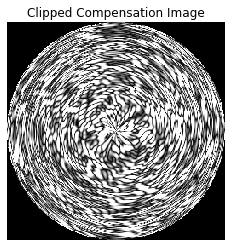

In [24]:
imc = np.copy(riw.img_compensation)
imc_mean = np.mean(imc)
radius = 10
imc = np.clip(imc, imc_mean - radius, imc_mean + radius)

ImageUtil.show1(imc, 'Clipped Compensation Image')

PSNR = 32.6219032510035


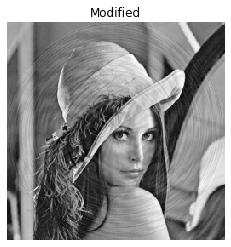

In [25]:
img_mod = my_image.get_y() + imc

print('PSNR = {}'.format(ImageUtil.psnr(my_image.get_y(), img_mod)))

ImageUtil.show1(img_mod, 'Modified')

'Transform PCET: [####################] 100.0%'

BER = 0.00%


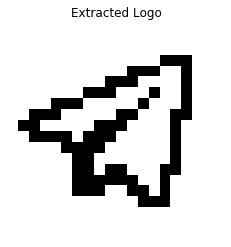

In [26]:
logo_mod = riw.extract(img_mod)

print('BER = {:.2%}'.format(ImageUtil.ber(my_logo.logo, logo_mod)))

ImageUtil.show1(logo_mod, 'Extracted Logo')

# Method 2

In [22]:
class RIW2:
    
    def __init__(self, image_size, logo_size, max_momen, q_step, batch = 10, seed = 1234):
        self.image_size = image_size
        self.logo_size = logo_size
        self.max_momen = max_momen
        self.q_step = q_step
        self.batch = batch
        self.seed = seed
        
    def generate_compensation(self, image, logo):
        
        # Error Handle
        image_size, *_ = image.shape
        if(image_size != self.image_size):
            raise Exception('Image size {} doesn\'t match to {}.'.format(image_size, self.image_size))
        logo_size, *_ = logo.shape
        if(logo_size != self.logo_size):
            raise Exception('Logo size {} doesn\'t match {}.'.format(logo_size, self.logo_size))
        
        # Transform Image
        transformer = PHT(self.image_size, self.max_momen, self.batch)
        momen = transformer.pcet(image)
        
        # Select random position to embed
        momen_logo = np.zeros((2 * self.max_momen + 1, 2 * self.max_momen + 1))
        momen_logo_filter = np.zeros((2 * self.max_momen + 1, 2 * self.max_momen + 1))
        logo_flatten = logo.flatten()
        logo_position = self.generate_random_position(len(logo_flatten), 0, 2 * self.max_momen + 1)
        for i in range(len(logo_flatten)):
            (n, m) = logo_position[i]
            momen_logo[n + self.max_momen, m + self.max_momen] = logo_flatten[i]
            momen_logo_filter[n + self.max_momen, m + self.max_momen] = 1
        
        momen_logo = momen_logo + np.rot90(np.rot90(momen_logo))
        momen_logo_filter = momen_logo_filter + np.rot90(np.rot90(momen_logo_filter))
        
        # Calculate momen modification
        momen_expected = 2 * self.q_step * np.round(np.abs(momen) / 2 / self.q_step)
        momen_expected = momen_expected + self.q_step / 2 * (momen_logo == 1)
        momen_expected = momen_expected - self.q_step / 2 * (momen_logo == 0)
        momen_expected = momen_expected + 2 * self.q_step * (momen_expected < 0)

        momen_diff = momen_expected - np.abs(momen)
        momen_diff = momen_diff / (np.abs(momen) + 0.000000001) * momen

        # Generating compensation image
        momen_compensation = momen_diff * momen_logo_filter
        img_compensation = transformer.inverse_pcet(momen_compensation)
        
        imc_limit = 8
        return np.clip(img_compensation, -imc_limit, imc_limit)


#         imc_selector = np.logical_or(img_compensation < -imc_limit, img_compensation > imc_limit)
#         img_compensation[imc_selector] = imc_limit
        
#         return img_compensation
        
#         img_reconstruction = transformer.inverse_pcet(momen)
#         return img_compensation * image / (np.abs(img_reconstruction) + 0.000000001)
        
    def embed(self, image, logo):
        self.img_compensation = self.generate_compensation(image, logo)

        # Modifying image
        img_y_watermarked = image + self.img_compensation
        return img_y_watermarked
        
    def extract(self, image):
        
        # Error Handle
        image_size, *_ = image.shape
        if(image_size != self.image_size):
            raise Exception('Image size {} doesn\'t match to {}.'.format(image_size, self.image_size))
        
        # Transform Image
        transformer = PHT(self.image_size, self.max_momen, self.batch)
        momen = transformer.pcet(image)
        
        # Calculate extracted bit
        momen_logo = ((np.abs(momen) - 2 * self.q_step * np.round(np.abs(momen) / 2 / self.q_step)) > 0) * 1
        momen_logo_filter = np.zeros((2 * self.max_momen + 1, 2 * self.max_momen + 1))
        
        # Extracting watermark
        logo_flatten = np.array([])
        logo_position = self.generate_random_position(self.logo_size * self.logo_size, 0, 2 * self.max_momen + 1)
        for i in range(self.logo_size * self.logo_size):
            (n, m) = logo_position[i]
            momen_logo_filter[n + self.max_momen, m + self.max_momen] = 1
            binary_value = momen_logo[n + self.max_momen, m + self.max_momen]
            logo_flatten = np.append(logo_flatten, binary_value)
        
        logo_extracted = logo_flatten.reshape((self.logo_size, self.logo_size))
        return logo_extracted
        
    def is_accurate(self, order, repetition):
        return (
            repetition % 4 != 0 and
            np.abs(order) + np.abs(repetition) <= self.max_momen and
            # repetition > 0 and
            order > 0
        )
    
    def generate_random_position(self, array_size, min_val, max_val):
        random.seed(10)
        arr = []
        for i in range(array_size):
            order, repetition  = random.randint(min_val, max_val), random.randint(min_val, max_val)
            trial = 0
            while(((order, repetition) in arr) or (not self.is_accurate(order, repetition))):
                trial = trial + 1
                if(trial > 5000):
                    print('Please use more momen')
                    return np.array([])
                    break
                order, repetition  = random.randint(min_val, max_val), random.randint(min_val, max_val)
            arr.append((order, repetition))
        return np.array(arr)

'Transform PCET: [####################] 100.0%'

'Inverse PCET: [####################] 100.0%'

PSNR = 33.733312565906964


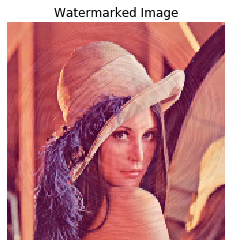

In [23]:
riw2 = RIW2(image_size, logo_size, logo_size * 2, 0.5, tf_step)
img_y_watermarked = riw2.embed(my_image.get_y(), my_logo.logo)
w_image = Image.copy(my_image)
w_image.set_y(img_y_watermarked)

print('PSNR = {}'.format(ImageUtil.psnr(my_image.image, w_image.image)))

ImageUtil.show1(w_image.image, 'Watermarked Image')

'Transform PCET: [####################] 100.0%'

BER = 4.25%


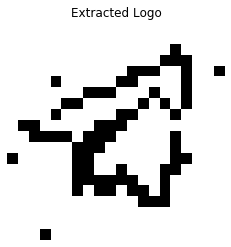

In [24]:
logo_extracted = riw2.extract(w_image.get_y())

print('BER = {:.2%}'.format(ImageUtil.ber(my_logo.logo, logo_extracted)))

ImageUtil.show1(logo_extracted, 'Extracted Logo')

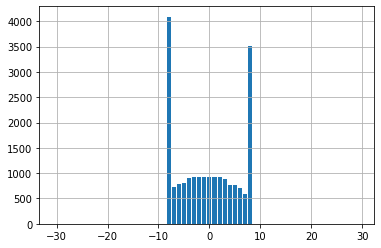

In [25]:
# Histogram of Compensation Image

fig_histogram = plt.figure()
histogram_data = riw2.img_compensation.flatten()
histogram_data = histogram_data[histogram_data != 0]
(yaxis, xaxis) = np.histogram(histogram_data, bins=np.linspace(-30, 30, 61))
xaxis = xaxis[0:len(yaxis)]
plt.bar(xaxis, yaxis)
plt.grid()
plt.show()